#UniMiB_SHAR_ADL_get_X_y_sub.ipynb
Loads the A-9 (ADL) portion of the UniMiB dataset from the Internet repository and converts the data into numpy arrays of X (data), y(labels), and sub (subject numbers)
>X = (samples, time steps per sample, accel_x/y/z/total_accel)  
>y = (samples, {0,1,...8}) #activity classification  
>s = subject number  

This is an intermediate representation that can be used to build the train/validate/test arrays.

Some functions are defined, but this is mostly meant to be run in interactive
mode with the files saved at the end.

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

Lee B. Hinkle, Texas State University, [IMICS Lab](https://imics.wp.txstate.edu/)  
TODO:
* Change activity from number to the abbreviation


In [1]:
import os
import shutil #https://docs.python.org/3/library/shutil.html
from shutil import unpack_archive # to unzip
#from shutil import make_archive # to create zip for storage
import requests #for downloading zip file
from scipy import io #for loadmat, matlab conversion
import time
import pandas as pd
import numpy as np
from numpy import savetxt
import matplotlib.pyplot as plt # for plotting - pandas uses matplotlib
from tabulate import tabulate # for verbose tables
from tensorflow.keras.utils import to_categorical # for one-hot encoding

In [2]:
#Helper functions especially useful in colab
from requests import get
def what_is_my_name():
    """returns the name of the running colab ipynb file"""
    #code is readily available on web - not original
    my_name = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
    return my_name
#credit https://stackoverflow.com/users/4944093/george-petrov for name method
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
def get_shapes(np_arr_list):
    """Returns text, each line is shape and dtype for numpy array in list
       example: print(get_shapes([X_train, X_test, y_train, y_test]))"""
    shapes = ""
    for i in np_arr_list:
        my_name = namestr(i,globals())
        shapes += (my_name[0] + " shape is " + str(i.shape) \
            + " data type is " + str(i.dtype) + "\n")
    return shapes

In [4]:
#credit https://stackoverflow.com/questions/9419162/download-returned-zip-file-from-url
#many other methods I tried failed to download the file properly
def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

In [5]:
def unimib_get_xys(
    verbose = True
    ):
    """Download UniMiB SHAR dataset and return X,y,sub arrays"""
    #Download and unzip original dataset
    if (not os.path.isfile('./UniMiB-SHAR.zip')):
        print("Downloading UniMiB-SHAR.zip file")
        download_url('https://www.dropbox.com/s/raw/x2fpfqj0bpf8ep6/UniMiB-SHAR.zip','./UniMiB-SHAR.zip')
    if (not os.path.isdir('./UniMiB-SHAR')):
        shutil.unpack_archive('./UniMiB-SHAR.zip','.','zip')
    #Convert .mat files to numpy ndarrays
    path_in = './UniMiB-SHAR/data'
    #loadmat loads matlab files as dictionary, keys: header, version, globals, data
    adl_data = io.loadmat(path_in + '/adl_data.mat')['adl_data']
    adl_names = io.loadmat(path_in + '/adl_names.mat', chars_as_strings=True)['adl_names']
    adl_labels = io.loadmat(path_in + '/adl_labels.mat')['adl_labels']

    if(verbose):
        headers = ("Raw data","shape", "object type", "data type")
        mydata = [("adl_data:", adl_data.shape, type(adl_data), adl_data.dtype),
                ("adl_labels:", adl_labels.shape ,type(adl_labels), adl_labels.dtype),
                ("adl_names:", adl_names.shape, type(adl_names), adl_names.dtype)]
        print(tabulate(mydata, headers=headers))
    #Reshape data and compute total (rms) acceleration
    #UniMiB SHAR data are 453 vector which is 151 accelX, 151 accely, 151 accelz
    num_samples = 151 
    adl_data = np.reshape(adl_data,(-1,num_samples,3), order='F') #uses Fortran order
    #Add total acceleration
    rms_accel = np.sqrt((adl_data[:,:,0]**2) + (adl_data[:,:,1]**2) + (adl_data[:,:,2]**2)) - 9.6
    adl_data = np.dstack((adl_data,rms_accel))
    if(verbose):
        headers = ("\nReshaped data","shape", "object type", "data type")
        mydata = [("adl_data:", adl_data.shape, type(adl_data), adl_data.dtype),
                ("adl_labels:", adl_labels.shape ,type(adl_labels), adl_labels.dtype),
                ("adl_names:", adl_names.shape, type(adl_names), adl_names.dtype)]
        print(tabulate(mydata, headers=headers))
    X = np.copy(adl_data)
    y = (adl_labels[:,0])-1 #matlab source was 1 indexed, change to 0 indexed
    sub = (adl_labels[:,1]) #subject numbers are in column 1 of labels
    
    #both y and sub are row arrays, change to single column arrays
    y = y[np.newaxis].T
    sub = sub[np.newaxis].T
    #check for nan - issue with resampled data
    bad_data_locations = np.argwhere(np.isnan(X))
    np.unique(bad_data_locations[:,0]) #[:,0] accesses just 1st column
    if (bad_data_locations.size==0):
        print("No NaN entries found")
    else:
        print("Warning: Output arrays contain NaN entries")
        print("execute print(X[99]) # to view single sample")
    return X, y, sub

In [6]:
#For interactive - delete or change to 'False' before saving as .py
if (True):
    X, y, sub = unimib_get_xys(verbose=True)
    shapes = get_shapes([X,y,sub])
    print("\nFinal Shapes\n", shapes)

Raw data     shape        object type              data type
-----------  -----------  -----------------------  -----------
adl_data:    (7579, 453)  <class 'numpy.ndarray'>  float64
adl_labels:  (7579, 3)    <class 'numpy.ndarray'>  uint8
adl_names:   (9, 1)       <class 'numpy.ndarray'>  object
                 shape           object type              data type
Reshaped data
---------------  --------------  -----------------------  -----------
adl_data:        (7579, 151, 4)  <class 'numpy.ndarray'>  float64
adl_labels:      (7579, 3)       <class 'numpy.ndarray'>  uint8
adl_names:       (9, 1)          <class 'numpy.ndarray'>  object
No NaN entries found

Final Shapes
 X shape is (7579, 151, 4) data type is float64
y shape is (7579, 1) data type is uint8
sub shape is (7579, 1) data type is uint8



In [ ]:
#show number of samples per subject
unique_elements, counts_elements = np.unique(sub, return_counts=True)
print(" subject #",int(unique_elements[np.argmin(counts_elements)]),
      "has ",np.amin(counts_elements)," samples (min)\n",
      "subject #",int(unique_elements[np.argmax(counts_elements)]),
      "has ",np.amax(counts_elements)," samples (max)\n")
print("Sample count per subject:")
print(np.asarray((unique_elements, counts_elements)))

 subject # 19 has  171  samples (min)
 subject # 24 has  462  samples (max)

Sample count per subject:
[[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
   19  20  21  22  23  24  25  26  27  28  29  30]
 [255 364 217 176 185 260 211 248 224 179 249 370 228 239 272 322 320 176
  171 363 183 307 218 462 242 199 220 193 307 219]]


In [ ]:
#Find min and max values for consistent plot scales
min_g = np.nanmin(X[::1])
max_g = np.nanmax(X[::1])
print ('min g value is',min_g,'max g value is',max_g)

min g value is -19.581081 max g value is 24.25047976483178


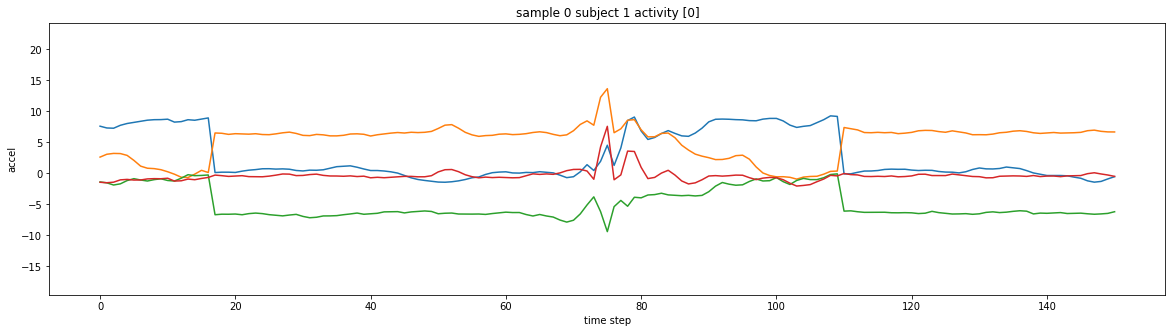

In [ ]:
#Plot a sample
sample_num = 0
plt.figure(figsize=(20,5))
plt.ylim([min_g, max_g])
plt.plot(X[sample_num])
plt.title('sample '+str(sample_num)+' subject '+str(int(sub[sample_num,0]))+' activity '+str(y[sample_num]))
plt.xlabel("time step")
plt.ylabel("accel")
plt.show()


In [ ]:
#save files into an existing directory
output_dir = '/content/drive/My Drive/Processed_Datasets/unimib'
if (os.path.isdir(output_dir)):
    #quick check for existing files, '.ipynb_checkpoints' file 
    #makes it more complicated to see if directory is empty
    if (not os.path.isfile(output_dir + '/X.npy')):
        summary = "UniMIB Data parsed into X, y, sub numpy arrays\n"
        summary += "Saved to " + output_dir + "\n"
        summary += "Generated by " + what_is_my_name()

        summary += " on " + time.strftime('%b-%d-%Y_%H%M', time.localtime())

        info_fname = output_dir+'/'+'info.txt'
        print("Saving info to ", info_fname)
        full_info = summary + "\n" + shapes
        if(bad_data_locations.size!=0):
            full_info += "WARNING: There may be NaN entries in the arrays\n"
        print(full_info)

        with open(info_fname, "w") as file_object:
            file_object.write(full_info)

        if True:
            np.save(output_dir + '/'+'X.npy',X)
            np.save(output_dir + '/'+'y.npy',y)
            np.save(output_dir + '/'+'sub.npy',sub)
    else:
        print("Error "+output_dir+" contains X.npy, please delete files")
else:
    print(output_dir + " not found, please create directory") 

Saving info to  /content/drive/My Drive/Processed_Datasets/unimib_test/info.txt
UniMIB Data parsed into X, y, sub numpy arrays
Saved to /content/drive/My Drive/Processed_Datasets/unimib_test
Generated by UniMiB_SHAR_ADL_get_X_y_sub.ipynb on Feb-12-2021_2301
X shape is (7579, 151, 4) data type is float64
y shape is (7579, 1) data type is uint8
sub shape is (7579, 1) data type is uint8

